In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('fd_tree_monitor.csv')

In [3]:
data['pid'] = pd.Categorical(data['pid'])

In [4]:
data.head()

,timestamp_epoch,pid,fd_total,fd_files,fd_sockets,fd_pipes,fd_anon,process,event
0,1763326680,1391644,4,3.0,0.0,0,0.0,python,NaN
1,1763326682,1391644,3,3.0,0.0,0,0.0,python,NaN
2,1763326684,1391644,102,32.0,22.0,38,10.0,python,NaN
3,1763326684,1391854,84,34.0,20.0,20,10.0,python,NaN
4,1763326684,1391855,86,34.0,20.0,22,10.0,python,NaN


In [5]:
data.nunique()

timestamp_epoch    18
pid                22
fd_total           45
fd_files           12
fd_sockets          5
fd_pipes           24
fd_anon             2
process             1
event               0
dtype: int64

<Axes: xlabel='timestamp_epoch', ylabel='fd_total'>

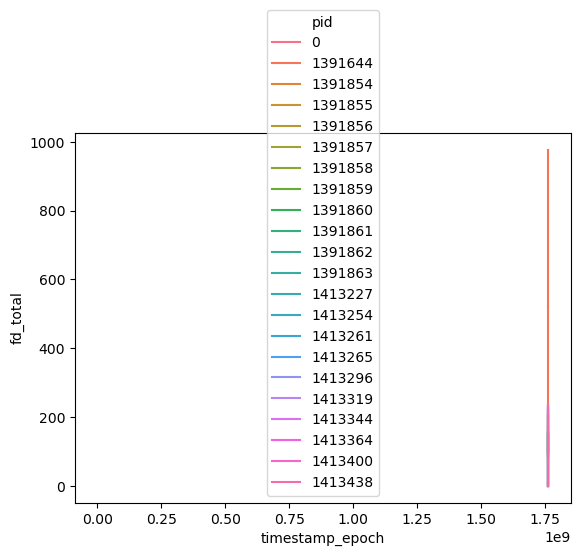

In [6]:
sns.lineplot(x='timestamp_epoch', 
             y='fd_total',
             hue='pid',
data=data)

Top leakiest PIDs:
pid
1391644    977
1413438    237
1413400    235
1413364    233
1413344    231
1413319    229
1413296    227
1413265    225
1413261    223
1413254    221
1413227    219
1391858    216
1391860    210
1391856    202
1391862    173
1391863    160
1391861    156
1391859    152
1391857    148
1391855    144
Name: fd_total, dtype: int64
Saved plot to fd_leak_curves.png


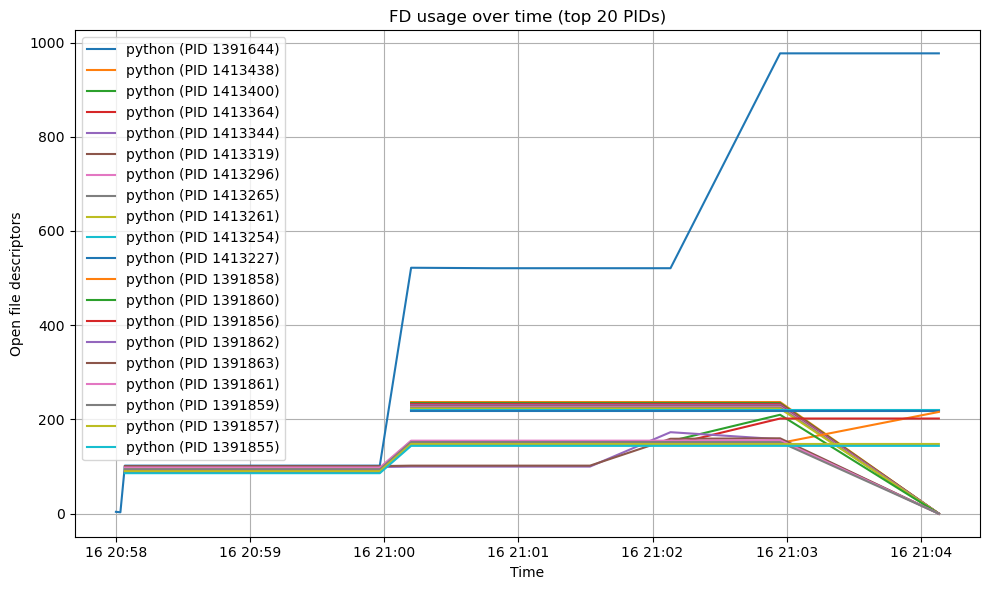

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

LOGFILE = "fd_tree_monitor.csv"
TOP_N = 20
OUTFILE = "fd_leak_curves.png"

# === Load ===
df = pd.read_csv(LOGFILE)

# Convert epoch → real time
df["time"] = pd.to_datetime(df["timestamp_epoch"], unit="s")

# Filter out explicit EXITED rows (optional)
df_live = df[(df["event"].isna()) | (df["event"] == "")].copy()

# Rank PIDs by max FD usage
max_fd = df_live.groupby("pid")["fd_total"].max().sort_values(ascending=False)
top_pids = max_fd.head(TOP_N).index

print("Top leakiest PIDs:")
print(max_fd.head(TOP_N))

pid_to_name = df_live.groupby("pid")["process"].first().to_dict()

# === Plot ===
plt.figure(figsize=(10, 6))

for pid in top_pids:
    sub = df_live[df_live["pid"] == pid].sort_values("time")
    label = f"{pid_to_name.get(pid, '?')} (PID {pid})"
    plt.plot(sub["time"], sub["fd_total"], label=label)

plt.xlabel("Time")
plt.ylabel("Open file descriptors")
plt.title(f"FD usage over time (top {TOP_N} PIDs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTFILE, dpi=150)
print(f"Saved plot to {OUTFILE}")
plt.show()